# Credit Risk Analysis

### NECESSARY IMPORTS

In [24]:
import sys
sys.path.append('..')
# from dotenv import load_dotenv #for env variables
from imp import reload #for testing
from sklearn.impute import SimpleImputer
from helper_functions import data_utils, config, evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile, chi2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#%matplotlib inline

## Modeling

In [4]:
reload(data_utils)

<module 'helper_functions.data_utils' from '/home/chris/Learning-2023/anyoneai_dir/endproj/credit-risk-analysis_chris/src/notebooks/../helper_functions/data_utils.py'>

In [5]:
app_train_cop = data_utils.cvs_df("../../dataset/","clean_data.csv")

The file has been loaded: ../../dataset/clean_data.csv


In [6]:
# order target at the final of dataset
current_cols_train = app_train_cop.columns.to_list()
idx_target = app_train_cop.columns.to_list().index("TARGET_LABEL_BAD=1")
if(app_train_cop.iloc[:,-1:].columns[0] != app_train_cop.iloc[:,idx_target:].columns[0]):
    features_cols = current_cols_train[:idx_target] + current_cols_train[idx_target+1:] + [current_cols_train[idx_target]]
    #crear un nuevo df
    app_train_cop = app_train_cop[features_cols]
else:
    print("Target is the last column")

## Normalization, Impute, Encoding

#### Split and Normalization, Impute, Encoding

In [7]:
reload(data_utils)
reload(config)
reload(evaluation)

<module 'helper_functions.evaluation' from '/home/chris/Learning-2023/anyoneai_dir/endproj/credit-risk-analysis_chris/src/notebooks/../helper_functions/evaluation.py'>

### Oversampling
It can be achieved in two ways: random oversampling and synthetic oversampling.


#### Aplicando SMOTE oversampling (syntethic oversampling)

new synthetic training records are made randomly by selecting one or more K-nearest neighbors for each of the minority classes

- Draw a random set from the minority class.
- For all the observations for the sample, locate the K-nearest neighbors. To obtain the distance between the neighbors, find the Euclidean distance.
- The next step is to find the vector between the current data point and the selected neighbor.
- Next, multiply a vector between 0 and 1.

To obtain the new dataset, add new samples to the current data point.
The only downfall of oversampling is that it can lead to overfitting due to duplication of the same information



In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
print('Original dataset shape %s' % Counter(y_train.ravel()))


model_chosen = LogisticRegression(max_iter=200,class_weight="balanced")
#model_chosen = RandomForestClassifier(max_depth=50, n_estimators=90, class_weight="balanced")
# pipeline
# 1:2 ratio
over = SMOTE(sampling_strategy=0.4, k_neighbors=10)
# 1:10 ratio
under = RandomUnderSampler(sampling_strategy=0.9)
steps = [("over",over),("under",under)]
pipeline = Pipeline(steps=steps)

#Please note that you should only balance the training data 
# and not the validation or testing data. 
# Balancing the validation and testing data would introduce data leakage 
# and lead to overestimating the model's performance.
# # transform the dataset
X_train_new, y_train_new = pipeline.fit_resample(X_train, y_train)
# summarize the new class distribution
print('New dataset shape %s' % Counter(y_train_new.ravel()))


Original dataset shape Counter({0.0: 26629, 1.0: 9324})
New dataset shape Counter({0.0: 11834, 1.0: 10651})


#### Feature Selection

two options:
- chi-squared statistic
- mutual information statistic.

-  Chi-squared statistic
-  The results of this test can be used for feature selection, where those features that are independent of the target variable can be removed from the dataset.

##### Chi-Squared Feature Selection

In [14]:
newl_columns_name = list(new_columns_name)

In [15]:
newl_columns_name = newl_columns_name[:-1]

In [16]:
#select only categoricas
# feature selection
def select_features_by_chi2(X_tr, y_tr, X_va,X_te):
    #fs = SelectKBest(score_func=chi2, k=5)
    fs = SelectPercentile(chi2, percentile=50)
    fs.fit(X_tr, y_tr)
    X_train_fsa = fs.transform(X_tr)
    X_val_fsa = fs.transform(X_va)
    X_test_fsa = fs.transform(X_te)
    return X_train_fsa, X_val_fsa, X_test_fsa, fs

In [17]:
X_train_fs, X_val_fs, X_test_fs, fs = select_features_by_chi2(X_train_new, y_train_new, X_val,X_test)
# what are scores for the features
fs_scores = pd.DataFrame(fs.scores_,columns=["FS_SCORE"],index=newl_columns_name)
fs_sorted_scores = fs_scores.sort_values(by="FS_SCORE",ascending=False)
fs_sorted_scores

,FS_SCORE
transform_cat_ord__AGE,314.092032
transform_cat_ohe__MARITAL_STATUS_single,90.282653
transform_cat_ohe__PAYMENT_DAY_15 - 30,83.194435
transform_boolean__FLAG_RESIDENCIAL_PHONE_False,69.394800
transform_cat_ohe__PAYMENT_DAY_1 - 14,61.130921
...,...
transform_cat_ohe__RESIDENCIAL_STATE_AM,0.021335
transform_boolean__HAS_DEPENDANTS_True,0.007355
transform_cat_ohe__RESIDENCIAL_STATE_PA,0.007291
transform_boolean__HAS_DEPENDANTS_False,0.003575


In [19]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

LR: 0.551632 (0.009106)
LDA: 0.562833 (0.013164)
KNN: 0.587109 (0.016407)
CART: 0.558988 (0.014141)
NB: 0.532633 (0.011124)
RF: 0.564422 (0.010597)


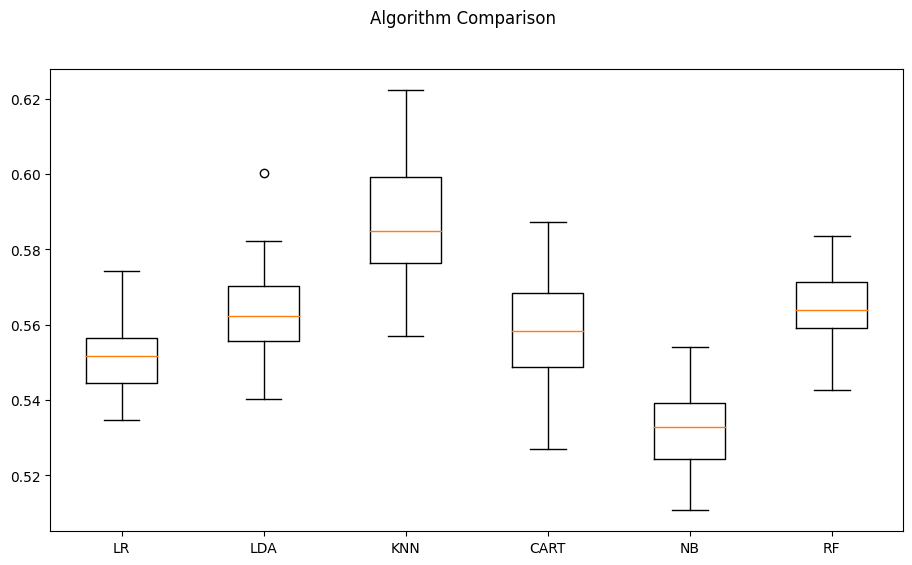

In [21]:
from sklearn.naive_bayes import GaussianNB
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression(max_iter=200,class_weight="balanced")))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
# models.append(('SVM', SVC(gamma='auto')))
# models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []

# ojo es precision lo que se evalua
scoring = 'precision'

for name, model in models:
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        cv_results = cross_val_score(model, X_train_fs, y_train_new.ravel(), cv=cv, scoring=scoring,n_jobs=-1)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

model score: 0.576
Model Performance metrics:
------------------------------
Accuracy: 0.5721437869229999
Precision: 0.7891657229143073
Recall: 0.5698514379174049
F1 Score: 0.6618124258013455

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.79      0.57      0.66      7337
           1       0.33      0.58      0.42      2650

    accuracy                           0.57      9987
   macro avg       0.56      0.57      0.54      9987
weighted avg       0.67      0.57      0.60      9987


Prediction Confusion Matrix:
------------------------------
      0     1
0  4181  3156
1  1117  1533


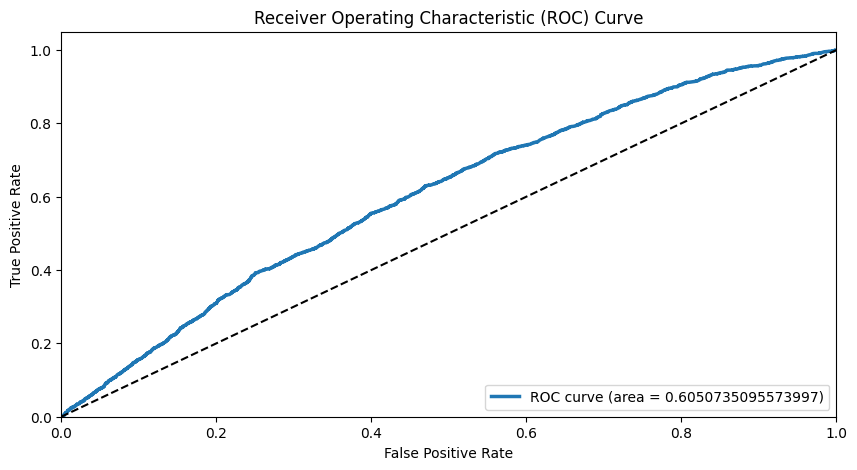

0.6050735095573997

In [22]:
# logistic regression
clf = LogisticRegression(max_iter=200,class_weight="balanced").fit(X_train_fs, y_train_new.ravel())
print("model score: %.3f" % clf.score(X_val_fs, y_val))
clf_preds = clf.predict(X_test_fs)

accuracy = evaluation.get_performance(clf_preds, y_test)
evaluation.plot_roc(clf, y_test, X_test_fs)

In [25]:
#save the model
pickle.dump(clf, open('logistic_model.pkl', 'wb'))